In [1]:
from brainlit.utils import session
import napari

In [2]:
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
sess = session.NeuroglancerSession(url=url, url_segments=url+"_segments", mip=0)

In [3]:
import numpy as np
from skimage import draw
import random
from cloudvolume.lib import Bbox
import pandas as pd
from tqdm import tqdm as tqdm

scale = sess.cv_segments.scales[0]["resolution"]
arr = []
sess.cv.progress = False  # don't print download
for seg_id in [2]:  # list of segments
    vertices = sess.cv_segments.skeleton.get(seg_id).vertices
    arrseg = np.zeros((len(vertices), 1))
    for i in tqdm(range(len(vertices))):
        v0 = (vertices[i]/scale).astype(int)  # point 0
        v1 = (vertices[i+1]/scale).astype(int)  # point 1
        coords = np.array(draw.line_nd(v0, v1))  # coords of line between points
        inds = random.sample(range(coords.shape[1]), 2)  # get X random points (here, 2)
        for ind in inds:
            coord = coords[:,ind]
            bbox = Bbox(np.subtract(coord,[3,3,3]), np.add(coord,[4,4,4]))  # get box around point
            data = sess.pull_bounds_img(bbox)  # get data
            data_off = sess.pull_bounds_img(bbox+[50,50,50])  # get (50,50,50)-shifted data
            arrseg[i] = [1, seg_id, i, ind, data.flatten()]
            arrseg[i] = [0, seg_id, i, ind, data_off.flatten()]
    arr = np.concatenate((arr, arrseg), axis=0)
header = ["label", "seg id", "vert id", "interp id", "data"]
df = pd.DataFrame(arr, columns=header)

100%|██████████| 50/50 [03:53<00:00,  4.67s/it]


In [4]:
import _pickle as pkl
pkl.dump(df, open("df.pkl", "wb"))

In [26]:
X = np.squeeze(np.array([i for i in df["data"]]))
y = df["label"]

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_score = clf.predict(X_test)

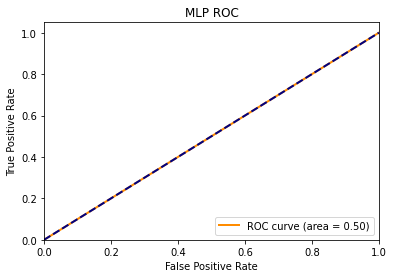

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC')
plt.legend(loc="lower right")
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
X_center = X[:, 171].reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_center, y, stratify=y, random_state=1)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_score = clf.predict(X_test)

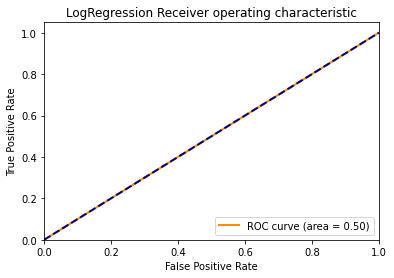

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogRegression Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()